## Answering Bussines Questions using SQL



In [1]:
import sqlite3
import pandas as pd
db = 'chinook.db'

## Helper Functions
Let's create a few helper function sto help us save time

In [2]:
# this functiontakes a SQL query as an argument and returns a pandas dataframe of that query.
def run_query(q):
   with sqlite3.connect(db) as conn:
    return pd.read_sql(q, conn)

## Details
The above funstion is a context manager that takes care of opening and closing the connection to the database.

This helps us avoid making changes to our database with the existense of an error querry in our queries.

In [3]:
# function that takes a SQL command as an argument and executes it using the sqlite module.
def run_command(q):
    with sqlite3.connect(db) as conn:
        conn.isolation_leel = None #autocommit changes in sqlite
        conn.execute(c)

## Details

The *run_command()* function runs sql queries that don't return tables.

In [4]:
def show_tables():
    q ='''
    SELECT 
        name,
        type
    FROM
    sqlite_master
    WHERE type IN ("table", "view");
    '''
    return run_query(q)


show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Details

the show() function returns a list of all tables and views in the database.


## Selecting Albums to purchase

In [5]:
albums_to_purchase = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


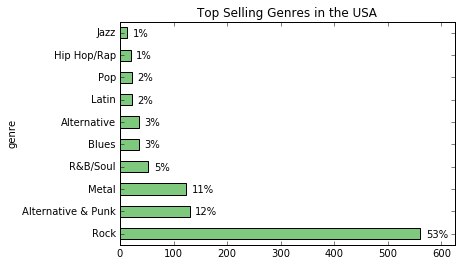

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

genre_sales_usa = run_query(albums_to_purchase)

genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

From the output above, we can conclude that the top 3 genres sold in the US are Rock, Alternative & Punk and Metal. 

## Suggestion

The first 3 albums to be added to the music store should fall within these 3 genres for improved marketing.



Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

    Red Tone (Punk)
    Slim Jim Bites (Metal)
    Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.


## ANalyzing Employee Sales Performance

Let's find the total dollar amount of sales assigned to each sales support agent within the company.

In [13]:
employee_sales_performance = '''
WITH customer_support_rep_sales AS
    (
     SELECT
         i.customer_id,
         c.support_rep_id,
         SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 1,2
    )

SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(csrs.total) total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY 1;
'''

run_query(employee_sales_performance)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


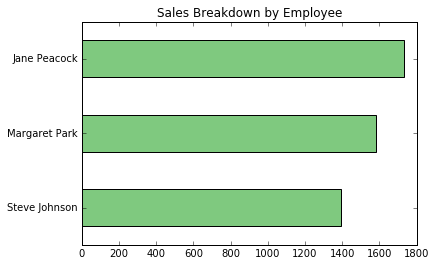

In [14]:
employee_sales = run_query(employee_sales_performance)

employee_sales.set_index("employee", drop=True, inplace=True)
employee_sales.sort_values("total_sales", inplace=True)
employee_sales.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
    colormap=plt.cm.Accent
)
plt.ylabel('')
plt.show()